# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-kmeans'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.517, Accuracy: 0.8084, F1 Micro: 0.1945, F1 Macro: 0.1492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3888, Accuracy: 0.833, F1 Micro: 0.3853, F1 Macro: 0.2571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3143, Accuracy: 0.8577, F1 Micro: 0.5631, F1 Macro: 0.4948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2473, Accuracy: 0.8752, F1 Micro: 0.6933, F1 Macro: 0.6817
Epoch 5/10, Train Loss: 0.2025, Accuracy: 0.8763, F1 Micro: 0.6686, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1508, Accuracy: 0.8814, F1 Micro: 0.6926, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.8811, F1 Micro: 0.7024, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.8811, F1 Micro: 0.6867, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.8858, F1 Micro: 0.7146, F1 Macro: 0.704
Epoch 10/10, Train Loss: 0.0622, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4907, Accuracy: 0.8275, F1 Micro: 0.3244, F1 Macro: 0.2248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.335, Accuracy: 0.8627, F1 Micro: 0.5992, F1 Macro: 0.5166
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2745, Accuracy: 0.8803, F1 Micro: 0.6987, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.206, Accuracy: 0.8844, F1 Micro: 0.6989, F1 Macro: 0.6838
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.8791, F1 Micro: 0.6644, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.8853, F1 Micro: 0.7259, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.8867, F1 Micro: 0.723, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.8894, F1 Micro: 0.7326, F1 Macro: 0.7283
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.8873, F1 Micro: 0.7293, F1 Macro: 0.7252
Epoch 10/10, Train Loss: 0.0514, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4713, Accuracy: 0.8327, F1 Micro: 0.3904, F1 Macro: 0.2502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.8789, F1 Micro: 0.7, F1 Macro: 0.6865
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.8702, F1 Micro: 0.6275, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.8917, F1 Micro: 0.7342, F1 Macro: 0.7276
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.8798, F1 Micro: 0.6534, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.8897, F1 Micro: 0.7453, F1 Macro: 0.7336
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.89, F1 Micro: 0.7228, F1 Macro: 0.7163
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.8919, F1 Micro: 0.7363, F1 Macro: 0.7299
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.888, F1 Micro: 0.7444, F1 Macro: 0.7393
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.8927, F1 Micro: 0.7405, F1 Macro: 0.7366

 Iteration 1969: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.8452, F1 Micro: 0.4698, F1 Macro: 0.3726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.308, Accuracy: 0.8647, F1 Micro: 0.5907, F1 Macro: 0.5551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.8936, F1 Micro: 0.7337, F1 Macro: 0.7223
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.893, F1 Micro: 0.7281, F1 Macro: 0.7011
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.8856, F1 Micro: 0.689, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.8956, F1 Micro: 0.7606, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.8953, F1 Micro: 0.7574, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.895, F1 Micro: 0.7456, F1 Macro: 0.7427
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.8948, F1 Micro: 0.7436, F1 Macro: 0.736
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.8939, F1 Micro: 0.7494, F1 Macro: 0.7478

 Iteration 2394: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8473, F1 Micro: 0.5113, F1 Macro: 0.3906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2876, Accuracy: 0.8858, F1 Micro: 0.7157, F1 Macro: 0.7052
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.8858, F1 Micro: 0.7027, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.8963, F1 Micro: 0.7562, F1 Macro: 0.7563
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.8906, F1 Micro: 0.7218, F1 Macro: 0.7126
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.8942, F1 Micro: 0.7639, F1 Macro: 0.7619
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.8969, F1 Micro: 0.7556, F1 Macro: 0.7507
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.8933, F1 Micro: 0.7452, F1 Macro: 0.7372
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.8966, F1 Micro: 0.7526, F1 Macro: 0.745
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.8922, F1 Micro: 0.735, F1 Macro: 0.7253

 Iteration 2777: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4372, Accuracy: 0.8428, F1 Micro: 0.4436, F1 Macro: 0.3587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2868, Accuracy: 0.8819, F1 Micro: 0.6834, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.8938, F1 Micro: 0.747, F1 Macro: 0.7432
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.8919, F1 Micro: 0.7033, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.8977, F1 Micro: 0.7524, F1 Macro: 0.741
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.8948, F1 Micro: 0.7364, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.8952, F1 Micro: 0.7568, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.8923, F1 Micro: 0.7544, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.8939, F1 Micro: 0.751, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0385, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8662, F1 Micro: 0.607, F1 Macro: 0.5437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.888, F1 Micro: 0.7142, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8998, F1 Micro: 0.7678, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9023, F1 Micro: 0.7691, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9003, F1 Micro: 0.767, F1 Macro: 0.7636
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.8986, F1 Micro: 0.7537, F1 Macro: 0.7455
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.8964, F1 Micro: 0.7366, F1 Macro: 0.7237
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.8994, F1 Micro: 0.7551, F1 Macro: 0.7476
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8994, F1 Micro: 0.7643, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.897, F1 Micro: 0.7523, F1 Macro: 0.7518

 Iteration 3432: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4217, Accuracy: 0.8791, F1 Micro: 0.6799, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.8911, F1 Micro: 0.7312, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9011, F1 Micro: 0.7777, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.8986, F1 Micro: 0.7497, F1 Macro: 0.7466
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9036, F1 Micro: 0.7751, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9028, F1 Micro: 0.7662, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9042, F1 Micro: 0.773, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9017, F1 Micro: 0.7606, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9027, F1 Micro: 0.7818, F1 Macro: 0.782
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9005, F1 Micro: 0.7636, F1 Macro: 0.7598

 Iteration 3711: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4183, Accuracy: 0.8736, F1 Micro: 0.6971, F1 Macro: 0.6921
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.8873, F1 Micro: 0.6964, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9028, F1 Micro: 0.7772, F1 Macro: 0.7758
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.8964, F1 Micro: 0.7345, F1 Macro: 0.7301
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9028, F1 Micro: 0.7688, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9066, F1 Micro: 0.7767, F1 Macro: 0.7728
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9038, F1 Micro: 0.7633, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9042, F1 Micro: 0.7804, F1 Macro: 0.7809
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9006, F1 Micro: 0.7677, F1 Macro: 0.7658
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.8984, F1 Micro: 0.7679, F1 Macro: 0.766

 Iteration 3886: Accuracy: 0.9042, F1 Micro: 0.7804

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4132, Accuracy: 0.8725, F1 Micro: 0.6418, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.8872, F1 Micro: 0.6907, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9011, F1 Micro: 0.7719, F1 Macro: 0.7684
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.898, F1 Micro: 0.743, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9034, F1 Micro: 0.773, F1 Macro: 0.7689
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9027, F1 Micro: 0.7688, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.905, F1 Micro: 0.7751, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9, F1 Micro: 0.7784, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9022, F1 Micro: 0.7751, F1 Macro: 0.7733
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.401, Accuracy: 0.8756, F1 Micro: 0.7116, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.8941, F1 Micro: 0.7288, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.8988, F1 Micro: 0.7672, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.905, F1 Micro: 0.7842, F1 Macro: 0.7826
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.8978, F1 Micro: 0.7411, F1 Macro: 0.7202
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.8997, F1 Micro: 0.7533, F1 Macro: 0.7361
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9006, F1 Micro: 0.7722, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9033, F1 Micro: 0.779, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9042, F1 Micro: 0.7737, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9064, F1 Micro: 0.7771, F1 Macro: 0.775

 Iteration 4330: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8702, F1 Micro: 0.6158, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.895, F1 Micro: 0.7354, F1 Macro: 0.7268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9031, F1 Micro: 0.7754, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9006, F1 Micro: 0.7848, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9067, F1 Micro: 0.7729, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9058, F1 Micro: 0.7855, F1 Macro: 0.7869
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9058, F1 Micro: 0.7703, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9061, F1 Micro: 0.7716, F1 Macro: 0.7638
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9061, F1 Micro: 0.7775, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9023, F1 Micro: 0.78, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8813, F1 Micro: 0.6933, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2556, Accuracy: 0.8975, F1 Micro: 0.7463, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9016, F1 Micro: 0.7697, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9027, F1 Micro: 0.7876, F1 Macro: 0.7856
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9027, F1 Micro: 0.7618, F1 Macro: 0.7543
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9038, F1 Micro: 0.774, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9045, F1 Micro: 0.7839, F1 Macro: 0.7841
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.8992, F1 Micro: 0.7669, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.8983, F1 Micro: 0.7751, F1 Macro: 0.7744

 Iteration 4663: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8792, F1 Micro: 0.6975, F1 Macro: 0.6925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.902, F1 Micro: 0.7684, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9052, F1 Micro: 0.7726, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9031, F1 Micro: 0.7828, F1 Macro: 0.7807
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9027, F1 Micro: 0.7573, F1 Macro: 0.7487
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9075, F1 Micro: 0.7783, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.8998, F1 Micro: 0.7809, F1 Macro: 0.7814
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9028, F1 Micro: 0.7788, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9053, F1 Micro: 0.7828, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9023, F1 Micro: 0.7788, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8791, F1 Micro: 0.6794, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8998, F1 Micro: 0.7673, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9044, F1 Micro: 0.7794, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.902, F1 Micro: 0.7861, F1 Macro: 0.7843
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9041, F1 Micro: 0.759, F1 Macro: 0.7447
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9019, F1 Micro: 0.7778, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9055, F1 Micro: 0.7861, F1 Macro: 0.7834
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9062, F1 Micro: 0.7832, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9031, F1 Micro: 0.7683, F1 Macro: 0.7622
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9013, F1 Micro: 0.7741, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3832, Accuracy: 0.885, F1 Micro: 0.7266, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8975, F1 Micro: 0.762, F1 Macro: 0.7518
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9022, F1 Micro: 0.7518, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9062, F1 Micro: 0.7863, F1 Macro: 0.7831
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9041, F1 Micro: 0.7809, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9016, F1 Micro: 0.7716, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.902, F1 Micro: 0.7796, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9041, F1 Micro: 0.7761, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9025, F1 Micro: 0.7721, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9017, F1 Micro: 0.7709, F1 Macro: 0.7683

 Iteration 5263: Accuracy: 0.9062, F1 Micro: 0.7863, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8838, F1 Micro: 0.7275, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8972, F1 Micro: 0.7397, F1 Macro: 0.723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9045, F1 Micro: 0.7809, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9016, F1 Micro: 0.7814, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.903, F1 Micro: 0.7785, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9022, F1 Micro: 0.782, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9052, F1 Micro: 0.7758, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9083, F1 Micro: 0.7819, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9053, F1 Micro: 0.7729, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0323, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8891, F1 Micro: 0.7261, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.8969, F1 Micro: 0.7428, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9053, F1 Micro: 0.7599, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9055, F1 Micro: 0.7799, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9066, F1 Micro: 0.7829, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9083, F1 Micro: 0.782, F1 Macro: 0.7804
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9025, F1 Micro: 0.7741, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.903, F1 Micro: 0.7746, F1 Macro: 0.7699
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9045, F1 Micro: 0.7728, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.907, F1 Micro: 0.775, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.885, F1 Micro: 0.7419, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.8983, F1 Micro: 0.7764, F1 Macro: 0.7749
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9039, F1 Micro: 0.7659, F1 Macro: 0.762
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9039, F1 Micro: 0.7628, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9078, F1 Micro: 0.7807, F1 Macro: 0.7748
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9013, F1 Micro: 0.7599, F1 Macro: 0.7471
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9042, F1 Micro: 0.7696, F1 Macro: 0.7607
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8989, F1 Micro: 0.7672, F1 Macro: 0.7615
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.905, F1 Micro: 0.7791, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9073, F1 Micro: 0.7833, F1 Macro: 0.7798

 Iteration 5841: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8864, F1 Micro: 0.707, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.233, Accuracy: 0.8995, F1 Micro: 0.7425, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9036, F1 Micro: 0.7742, F1 Macro: 0.7629
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9023, F1 Micro: 0.7679, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9036, F1 Micro: 0.7747, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9034, F1 Micro: 0.7807, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9042, F1 Micro: 0.785, F1 Macro: 0.7846
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9077, F1 Micro: 0.7794, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9027, F1 Micro: 0.783, F1 Macro: 0.7824
Epoch 10/10, Train Loss: 0.0357, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.8909, F1 Micro: 0.7309, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2336, Accuracy: 0.8998, F1 Micro: 0.7551, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.907, F1 Micro: 0.7805, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9081, F1 Micro: 0.7892, F1 Macro: 0.7852
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9031, F1 Micro: 0.7736, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9058, F1 Micro: 0.7754, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9081, F1 Micro: 0.7776, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9022, F1 Micro: 0.7849, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9045, F1 Micro: 0.7849, F1 Macro: 0.7837
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9014, F1 Micro: 0.7776, F1 Macro: 0.7759

 Iteration 6218: A

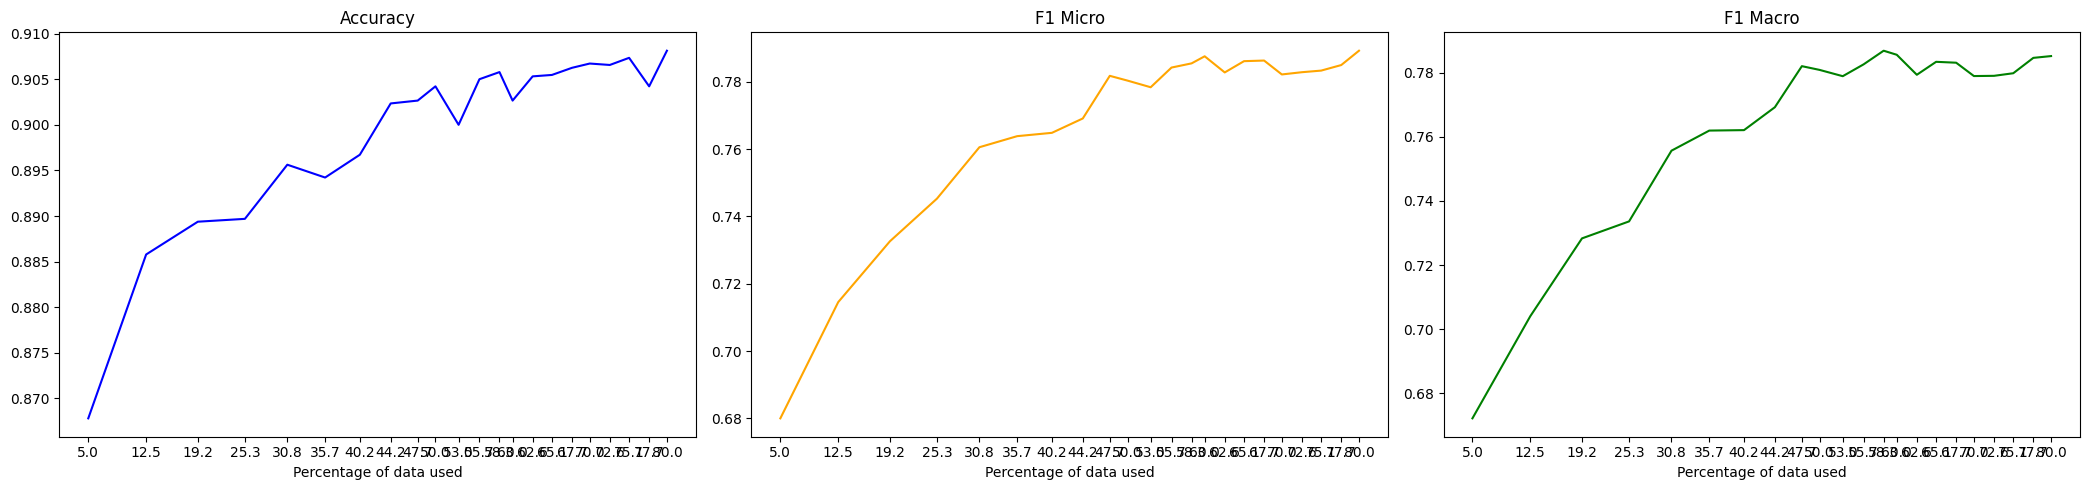

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.8077, F1 Micro: 0.1821, F1 Macro: 0.1404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3859, Accuracy: 0.8433, F1 Micro: 0.474, F1 Macro: 0.377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3183, Accuracy: 0.8577, F1 Micro: 0.561, F1 Macro: 0.4952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2721, Accuracy: 0.8736, F1 Micro: 0.6559, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2084, Accuracy: 0.8811, F1 Micro: 0.6903, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.8845, F1 Micro: 0.7089, F1 Macro: 0.6959
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.8833, F1 Micro: 0.6899, F1 Macro: 0.6781
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.8811, F1 Micro: 0.6905, F1 Macro: 0.6809
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.8791, F1 Micro: 0.6775, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4925, Accuracy: 0.822, F1 Micro: 0.2973, F1 Macro: 0.215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3493, Accuracy: 0.8641, F1 Micro: 0.6081, F1 Macro: 0.5149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2808, Accuracy: 0.8816, F1 Micro: 0.7129, F1 Macro: 0.7081
Epoch 4/10, Train Loss: 0.2242, Accuracy: 0.8861, F1 Micro: 0.7064, F1 Macro: 0.6885
Epoch 5/10, Train Loss: 0.1738, Accuracy: 0.8875, F1 Micro: 0.7099, F1 Macro: 0.7003
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.8891, F1 Micro: 0.7051, F1 Macro: 0.6835
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.8831, F1 Micro: 0.6809, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.8913, F1 Micro: 0.7575, F1 Macro: 0.7573
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.8892, F1 Micro: 0.7183, F1 Macro: 0.7026
Epoch 10/10, Train Loss: 0.0534, Accuracy: 0.89, F1 Micro: 0.7421, F1 Macro: 0.7401

 Iteration 1496: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4632, Accuracy: 0.8434, F1 Micro: 0.4721, F1 Macro: 0.3643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3186, Accuracy: 0.8753, F1 Micro: 0.65, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.887, F1 Micro: 0.7179, F1 Macro: 0.7103
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.8856, F1 Micro: 0.6858, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.8927, F1 Micro: 0.7344, F1 Macro: 0.7315
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.8897, F1 Micro: 0.7146, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.8939, F1 Micro: 0.7467, F1 Macro: 0.7489
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.8878, F1 Micro: 0.7459, F1 Macro: 0.7451
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.8936, F1 Micro: 0.7359, F1 Macro: 0.7379
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.895, F1 Micro: 0.7415, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8394, F1 Micro: 0.4205, F1 Macro: 0.3358
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3004, Accuracy: 0.8823, F1 Micro: 0.7329, F1 Macro: 0.7254
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.8911, F1 Micro: 0.7304, F1 Macro: 0.7205
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.8866, F1 Micro: 0.6908, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.8931, F1 Micro: 0.7578, F1 Macro: 0.7555
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.8866, F1 Micro: 0.6813, F1 Macro: 0.6598
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.8959, F1 Micro: 0.7553, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.8948, F1 Micro: 0.7392, F1 Macro: 0.7255
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.8931, F1 Micro: 0.7369, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.8963, F1 Micro: 0.7594, F1 Macro: 0.7586

 Iteration 2394: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4433, Accuracy: 0.8564, F1 Micro: 0.5511, F1 Macro: 0.4556
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2906, Accuracy: 0.8816, F1 Micro: 0.6766, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.8925, F1 Micro: 0.7298, F1 Macro: 0.713
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.8953, F1 Micro: 0.7276, F1 Macro: 0.7203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.8942, F1 Micro: 0.7676, F1 Macro: 0.7693
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.8969, F1 Micro: 0.7535, F1 Macro: 0.7429
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.8953, F1 Micro: 0.7656, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.8959, F1 Micro: 0.7417, F1 Macro: 0.7315
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.8969, F1 Micro: 0.7434, F1 Macro: 0.7334
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.8963, F1 Micro: 0.7436, F1 Macro: 0.7425

 Iteration 2777: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4256, Accuracy: 0.8553, F1 Micro: 0.5285, F1 Macro: 0.4433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.8786, F1 Micro: 0.662, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.8984, F1 Micro: 0.7655, F1 Macro: 0.7626
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.8966, F1 Micro: 0.7537, F1 Macro: 0.7453
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.8959, F1 Micro: 0.7425, F1 Macro: 0.7383
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.902, F1 Micro: 0.76, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.8948, F1 Micro: 0.7644, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.8938, F1 Micro: 0.7287, F1 Macro: 0.7081
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.8997, F1 Micro: 0.7626, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9006, F1 Micro: 0.7576, F1 Macro: 0.7526

 Iteration 3122: Accuracy: 0.8984, F1 Micro: 0.7655, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8639, F1 Micro: 0.5905, F1 Macro: 0.5436
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.8961, F1 Micro: 0.7523, F1 Macro: 0.7484
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.8955, F1 Micro: 0.7301, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9011, F1 Micro: 0.7612, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9039, F1 Micro: 0.772, F1 Macro: 0.7693
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9013, F1 Micro: 0.7707, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.8998, F1 Micro: 0.7687, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.8995, F1 Micro: 0.7419, F1 Macro: 0.7316
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9022, F1 Micro: 0.7699, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8756, F1 Micro: 0.6658, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.8934, F1 Micro: 0.7325, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9005, F1 Micro: 0.7604, F1 Macro: 0.7558
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.8967, F1 Micro: 0.7336, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9033, F1 Micro: 0.7681, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9041, F1 Micro: 0.7678, F1 Macro: 0.7597
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.8997, F1 Micro: 0.7581, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9008, F1 Micro: 0.7693, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.8981, F1 Micro: 0.7758, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0321, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4111, Accuracy: 0.8791, F1 Micro: 0.6838, F1 Macro: 0.6748
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.8763, F1 Micro: 0.635, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.902, F1 Micro: 0.7563, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.8994, F1 Micro: 0.7731, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.8997, F1 Micro: 0.7807, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9022, F1 Micro: 0.7704, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9011, F1 Micro: 0.7672, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.903, F1 Micro: 0.7596, F1 Macro: 0.7508
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8984, F1 Micro: 0.7703, F1 Macro: 0.7682
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9027, F1 Micro: 0.7742, F1 Macro: 0.7743

 Iteration 3886: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8791, F1 Micro: 0.6794, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.8989, F1 Micro: 0.7622, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.903, F1 Micro: 0.7672, F1 Macro: 0.7627
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9, F1 Micro: 0.7661, F1 Macro: 0.7607
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9044, F1 Micro: 0.7628, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.8998, F1 Micro: 0.7692, F1 Macro: 0.7619
Epoch 7/10, Train Loss: 0.0637, Accuracy: 0.9008, F1 Micro: 0.7683, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8994, F1 Micro: 0.7744, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9025, F1 Micro: 0.7723, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0356, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8766, F1 Micro: 0.6681, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.8916, F1 Micro: 0.7295, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9008, F1 Micro: 0.7544, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.905, F1 Micro: 0.7629, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.8988, F1 Micro: 0.7828, F1 Macro: 0.7848
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9028, F1 Micro: 0.7615, F1 Macro: 0.758
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9033, F1 Micro: 0.771, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9038, F1 Micro: 0.7739, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9052, F1 Micro: 0.771, F1 Macro: 0.7665
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.8997, F1 Micro: 0.7699, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3988, Accuracy: 0.8758, F1 Micro: 0.6587, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9028, F1 Micro: 0.7782, F1 Macro: 0.7773
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.902, F1 Micro: 0.7513, F1 Macro: 0.744
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9028, F1 Micro: 0.753, F1 Macro: 0.7382
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9031, F1 Micro: 0.768, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9023, F1 Micro: 0.777, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9019, F1 Micro: 0.7721, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9016, F1 Micro: 0.7724, F1 Macro: 0.7666
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9028, F1 Micro: 0.7718, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9039, F1 Micro: 0.7758, F1 Macro: 0.7711

 Iteration 4530: Accuracy: 0.9028, F1 Micro: 0.7782, F1 Macro: 0.7773
                   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8853, F1 Micro: 0.7271, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.8983, F1 Micro: 0.7414, F1 Macro: 0.7326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9017, F1 Micro: 0.7675, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9047, F1 Micro: 0.7696, F1 Macro: 0.7646
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9009, F1 Micro: 0.7429, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.902, F1 Micro: 0.7736, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9047, F1 Micro: 0.7623, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9036, F1 Micro: 0.7744, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7747
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8769, F1 Micro: 0.6541, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9011, F1 Micro: 0.7662, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9053, F1 Micro: 0.7809, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9073, F1 Micro: 0.7843, F1 Macro: 0.7812
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9031, F1 Micro: 0.7794, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9061, F1 Micro: 0.7811, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9081, F1 Micro: 0.7824, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9059, F1 Micro: 0.7793, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9028, F1 Micro: 0.7741, F1 Macro: 0.7718

 Iteration 4863: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3919, Accuracy: 0.8872, F1 Micro: 0.7086, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9028, F1 Micro: 0.766, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9008, F1 Micro: 0.7762, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.902, F1 Micro: 0.784, F1 Macro: 0.7826
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9045, F1 Micro: 0.7658, F1 Macro: 0.76
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9055, F1 Micro: 0.782, F1 Macro: 0.781
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.903, F1 Micro: 0.7769, F1 Macro: 0.7716
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9078, F1 Micro: 0.7824, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9005, F1 Micro: 0.7693, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8878, F1 Micro: 0.7221, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.8981, F1 Micro: 0.7392, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9047, F1 Micro: 0.7826, F1 Macro: 0.7758
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9044, F1 Micro: 0.7621, F1 Macro: 0.7505
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.907, F1 Micro: 0.7702, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9084, F1 Micro: 0.7852, F1 Macro: 0.7817
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9059, F1 Micro: 0.7845, F1 Macro: 0.7839
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9064, F1 Micro: 0.7772, F1 Macro: 0.7722
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9048, F1 Micro: 0.7717, F1 Macro: 0.7656
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9014, F1 Micro: 0.7816, F1 Macro: 0.7809

 Iteration 5263: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.883, F1 Micro: 0.6722, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.8956, F1 Micro: 0.7592, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9053, F1 Micro: 0.7819, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9048, F1 Micro: 0.7703, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9002, F1 Micro: 0.7717, F1 Macro: 0.767
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9072, F1 Micro: 0.7717, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9013, F1 Micro: 0.7642, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9039, F1 Micro: 0.7696, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9062, F1 Micro: 0.784, F1 Macro: 0.7815
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9017, F1 Micro: 0.768, F1 Macro: 0.765

 Iteration 5441: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.8833, F1 Micro: 0.6902, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.9031, F1 Micro: 0.7621, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9058, F1 Micro: 0.7803, F1 Macro: 0.773
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9047, F1 Micro: 0.7702, F1 Macro: 0.7603
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.907, F1 Micro: 0.786, F1 Macro: 0.784
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9028, F1 Micro: 0.774, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9055, F1 Micro: 0.7855, F1 Macro: 0.7842
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9083, F1 Micro: 0.7787, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9036, F1 Micro: 0.7705, F1 Macro: 0.763

 Iteration 5641: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8922, F1 Micro: 0.7298, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9034, F1 Micro: 0.7706, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9053, F1 Micro: 0.7809, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9078, F1 Micro: 0.7878, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9059, F1 Micro: 0.7842, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9062, F1 Micro: 0.7837, F1 Macro: 0.7797
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9058, F1 Micro: 0.7776, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9009, F1 Micro: 0.775, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9055, F1 Micro: 0.7752, F1 Macro: 0.7701
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9002, F1 Micro: 0.7763, F1 Macro: 0.7762

 Iteration 5841: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8906, F1 Micro: 0.732, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.9034, F1 Micro: 0.785, F1 Macro: 0.7837
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.902, F1 Micro: 0.7586, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9045, F1 Micro: 0.7851, F1 Macro: 0.781
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9053, F1 Micro: 0.7754, F1 Macro: 0.7683
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9019, F1 Micro: 0.7757, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.9067, F1 Micro: 0.7809, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9058, F1 Micro: 0.7764, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9061, F1 Micro: 0.7814, F1 Macro: 0.7787
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.907, F1 Micro: 0.7826, F1 Macro: 0.7791

 Iteration 6041: Accuracy: 0.9045, F1 Micro: 0.7851, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.8911, F1 Micro: 0.7369, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.9019, F1 Micro: 0.7706, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9022, F1 Micro: 0.7823, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9069, F1 Micro: 0.7836, F1 Macro: 0.7793
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.905, F1 Micro: 0.7805, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9055, F1 Micro: 0.7733, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9039, F1 Micro: 0.7862, F1 Macro: 0.7876
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.8994, F1 Micro: 0.7672, F1 Macro: 0.7599
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9062, F1 Micro: 0.7717, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9022, F1 Micro: 0.774, F1 M

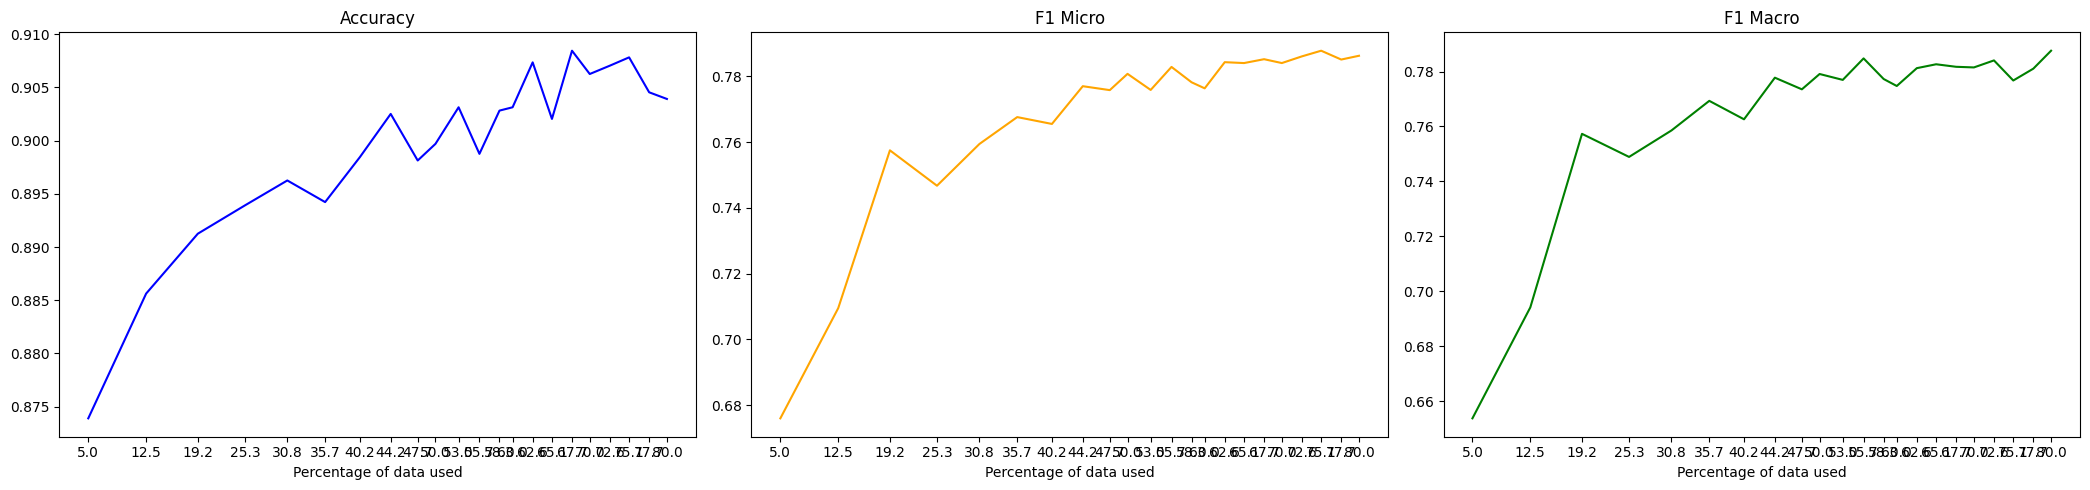

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.501, Accuracy: 0.8159, F1 Micro: 0.2429, F1 Macro: 0.1798
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3698, Accuracy: 0.8395, F1 Micro: 0.4342, F1 Macro: 0.3349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2973, Accuracy: 0.8555, F1 Micro: 0.5391, F1 Macro: 0.4825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.8634, F1 Micro: 0.5961, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1875, Accuracy: 0.878, F1 Micro: 0.6931, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.8809, F1 Micro: 0.704, F1 Macro: 0.6958
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.8772, F1 Micro: 0.6714, F1 Macro: 0.646
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.8839, F1 Micro: 0.7029, F1 Macro: 0.6941
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.8811, F1 Micro: 0.6986, F1 Macro: 0.6854
Epoch 10/10, Train Loss: 0.0547, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4816, Accuracy: 0.8202, F1 Micro: 0.2729, F1 Macro: 0.1973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3429, Accuracy: 0.8536, F1 Micro: 0.5557, F1 Macro: 0.4622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2684, Accuracy: 0.8734, F1 Micro: 0.6577, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.8914, F1 Micro: 0.7372, F1 Macro: 0.7341
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.8786, F1 Micro: 0.6591, F1 Macro: 0.6296
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.8895, F1 Micro: 0.7143, F1 Macro: 0.6908
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.8867, F1 Micro: 0.7025, F1 Macro: 0.6681
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.8892, F1 Micro: 0.7334, F1 Macro: 0.7311
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.8836, F1 Micro: 0.6868, F1 Macro: 0.6683
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.887, F1 Micro: 0.7396, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4708, Accuracy: 0.837, F1 Micro: 0.407, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.323, Accuracy: 0.875, F1 Micro: 0.6977, F1 Macro: 0.7003
Epoch 3/10, Train Loss: 0.2465, Accuracy: 0.8838, F1 Micro: 0.6869, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.8923, F1 Micro: 0.7252, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.8945, F1 Micro: 0.7299, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.8967, F1 Micro: 0.7466, F1 Macro: 0.7416
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.8945, F1 Micro: 0.7331, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.8939, F1 Micro: 0.7494, F1 Macro: 0.7459
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.893, F1 Micro: 0.7296, F1 Macro: 0.721
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4481, Accuracy: 0.8456, F1 Micro: 0.47, F1 Macro: 0.3826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.8861, F1 Micro: 0.7335, F1 Macro: 0.7276
Epoch 3/10, Train Loss: 0.2386, Accuracy: 0.8886, F1 Micro: 0.706, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.8995, F1 Micro: 0.7709, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.895, F1 Micro: 0.7375, F1 Macro: 0.7381
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.8977, F1 Micro: 0.7358, F1 Macro: 0.7224
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.8998, F1 Micro: 0.7554, F1 Macro: 0.7452
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.8986, F1 Micro: 0.7557, F1 Macro: 0.7507
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.8992, F1 Micro: 0.7608, F1 Macro: 0.757
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.8995, F1 Micro: 0.7663, F1 Macro: 0.7628

 Iteration 2394: Accuracy: 0.8995, F1 Micro: 0.7709, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.8627, F1 Micro: 0.6095, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2928, Accuracy: 0.882, F1 Micro: 0.6845, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.8953, F1 Micro: 0.7373, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.8884, F1 Micro: 0.7636, F1 Macro: 0.7637
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.8998, F1 Micro: 0.7408, F1 Macro: 0.7243
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.8997, F1 Micro: 0.7544, F1 Macro: 0.7523
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9016, F1 Micro: 0.7599, F1 Macro: 0.7561
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.8995, F1 Micro: 0.7449, F1 Macro: 0.7408
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9, F1 Micro: 0.7568, F1 Macro: 0.7514
Epoch 10/10, Train Loss: 0.037, Accuracy: 0.9005, F1 Micro: 0.7601, F1 Macro: 0.7568

 Iteration 2777: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.85, F1 Micro: 0.5016, F1 Macro: 0.4139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.8877, F1 Micro: 0.7208, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2202, Accuracy: 0.897, F1 Micro: 0.7287, F1 Macro: 0.7226
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.8881, F1 Micro: 0.6919, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.8964, F1 Micro: 0.7668, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9002, F1 Micro: 0.7604, F1 Macro: 0.7531
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9016, F1 Micro: 0.7642, F1 Macro: 0.7621
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9017, F1 Micro: 0.7615, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9038, F1 Micro: 0.7689, F1 Macro: 0.7658
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9022, F1 Micro: 0.7645, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4245, Accuracy: 0.8672, F1 Micro: 0.6212, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.8952, F1 Micro: 0.748, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.8978, F1 Micro: 0.7541, F1 Macro: 0.7469
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.8972, F1 Micro: 0.7362, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9013, F1 Micro: 0.7606, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9005, F1 Micro: 0.7766, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9006, F1 Micro: 0.7574, F1 Macro: 0.7505
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9, F1 Micro: 0.7727, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9023, F1 Micro: 0.772, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.8991, F1 Micro: 0.7724, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4117, Accuracy: 0.8759, F1 Micro: 0.6941, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8898, F1 Micro: 0.7192, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.8961, F1 Micro: 0.7373, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9033, F1 Micro: 0.7642, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9041, F1 Micro: 0.7692, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.8995, F1 Micro: 0.7741, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9006, F1 Micro: 0.7448, F1 Macro: 0.7354
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9027, F1 Micro: 0.7554, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9011, F1 Micro: 0.7795, F1 Macro: 0.7772
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8772, F1 Micro: 0.6984, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8983, F1 Micro: 0.7542, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.8998, F1 Micro: 0.7747, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9011, F1 Micro: 0.778, F1 Macro: 0.7756
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9009, F1 Micro: 0.7659, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.8938, F1 Micro: 0.77, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.8966, F1 Micro: 0.775, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9014, F1 Micro: 0.7749, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9016, F1 Micro: 0.7717, F1 Macro: 0.7719
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.8992, F1 Micro: 0.777, F1 Macro: 0.7759

 Iteration 3886: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8748, F1 Micro: 0.6528, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2634, Accuracy: 0.8923, F1 Micro: 0.7221, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9014, F1 Micro: 0.757, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9058, F1 Micro: 0.7612, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.902, F1 Micro: 0.7635, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9013, F1 Micro: 0.7749, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.8917, F1 Micro: 0.7694, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9041, F1 Micro: 0.779, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.8992, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8811, F1 Micro: 0.6928, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9, F1 Micro: 0.7567, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.8988, F1 Micro: 0.7759, F1 Macro: 0.7757
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.8994, F1 Micro: 0.7618, F1 Macro: 0.7569
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9061, F1 Micro: 0.773, F1 Macro: 0.7679
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.8989, F1 Micro: 0.7753, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9008, F1 Micro: 0.776, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9006, F1 Micro: 0.7745, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9, F1 Micro: 0.7762, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3947, Accuracy: 0.8731, F1 Micro: 0.647, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.8991, F1 Micro: 0.7562, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9025, F1 Micro: 0.7847, F1 Macro: 0.7847
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9013, F1 Micro: 0.7765, F1 Macro: 0.7721
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9002, F1 Micro: 0.7684, F1 Macro: 0.7664
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9027, F1 Micro: 0.773, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9016, F1 Micro: 0.7791, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.8972, F1 Micro: 0.7726, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8995, F1 Micro: 0.7691, F1 Macro: 0.7687
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9005, F1 Micro: 0.7732, F1 Macro: 0.7716

 Iteration 4530: Accuracy: 0.9025, F1 Micro: 0.7847,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8809, F1 Micro: 0.6959, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.8973, F1 Micro: 0.7646, F1 Macro: 0.7572
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9006, F1 Micro: 0.7514, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9041, F1 Micro: 0.7751, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9022, F1 Micro: 0.7782, F1 Macro: 0.7757
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9033, F1 Micro: 0.7703, F1 Macro: 0.763
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.905, F1 Micro: 0.7768, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.8959, F1 Micro: 0.7748, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9033, F1 Micro: 0.776, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9045, F1 Micro: 0.7738, F1 Macro: 0.7695

 Iteration 4663: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8838, F1 Micro: 0.7158, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.8945, F1 Micro: 0.7246, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9042, F1 Micro: 0.7824, F1 Macro: 0.7814
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9061, F1 Micro: 0.7631, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9073, F1 Micro: 0.7899, F1 Macro: 0.7854
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9089, F1 Micro: 0.7772, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.907, F1 Micro: 0.7805, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9067, F1 Micro: 0.7804, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9034, F1 Micro: 0.7779, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.897, F1 Micro: 0.7779, F1 Macro: 0.7781

 Iteration 4863: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8752, F1 Micro: 0.6469, F1 Macro: 0.6265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9, F1 Micro: 0.7578, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9047, F1 Micro: 0.7663, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9075, F1 Micro: 0.7749, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9072, F1 Micro: 0.7834, F1 Macro: 0.7798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9075, F1 Micro: 0.7847, F1 Macro: 0.7822
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9061, F1 Micro: 0.7627, F1 Macro: 0.7509
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9023, F1 Micro: 0.7786, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9039, F1 Micro: 0.7811, F1 Macro: 0.7818
Epoch 10/10, Train Loss: 0.0313, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.89, F1 Micro: 0.7371, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9006, F1 Micro: 0.7657, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9009, F1 Micro: 0.7755, F1 Macro: 0.7759
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.8991, F1 Micro: 0.7725, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9039, F1 Micro: 0.7815, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9009, F1 Micro: 0.7662, F1 Macro: 0.7572
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9061, F1 Micro: 0.7743, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7684
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.905, F1 Micro: 0.7763, F1 Macro: 0.7719
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.8969, F1 Micro: 0.7758, F1 Macro: 0.7751

 Iteration 5263: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8894, F1 Micro: 0.733, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.9, F1 Micro: 0.7561, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.8939, F1 Micro: 0.7708, F1 Macro: 0.7729
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9039, F1 Micro: 0.7703, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9025, F1 Micro: 0.7759, F1 Macro: 0.7717
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9022, F1 Micro: 0.7681, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9067, F1 Micro: 0.7762, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9038, F1 Micro: 0.7763, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9073, F1 Micro: 0.7732, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8869, F1 Micro: 0.7083, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9025, F1 Micro: 0.7651, F1 Macro: 0.7513
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9027, F1 Micro: 0.7571, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9022, F1 Micro: 0.7771, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9045, F1 Micro: 0.7793, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9092, F1 Micro: 0.7797, F1 Macro: 0.7719
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9066, F1 Micro: 0.7765, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.907, F1 Micro: 0.7865, F1 Macro: 0.7856
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9064, F1 Micro: 0.7807, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.027, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8856, F1 Micro: 0.6995, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.895, F1 Micro: 0.7689, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9022, F1 Micro: 0.7695, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9084, F1 Micro: 0.7809, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9069, F1 Micro: 0.7683, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9033, F1 Micro: 0.7807, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9027, F1 Micro: 0.7683, F1 Macro: 0.7636
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9047, F1 Micro: 0.7726, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9062, F1 Micro: 0.7915, F1 Macro: 0.7906
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9009, F1 Micro: 0.7829, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8817, F1 Micro: 0.6687, F1 Macro: 0.6384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9008, F1 Micro: 0.7668, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9072, F1 Micro: 0.7721, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9059, F1 Micro: 0.7816, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9081, F1 Micro: 0.788, F1 Macro: 0.78
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9034, F1 Micro: 0.7743, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9042, F1 Micro: 0.7754, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9045, F1 Micro: 0.7753, F1 Macro: 0.7666
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9039, F1 Micro: 0.7718, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8902, F1 Micro: 0.7413, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.9025, F1 Micro: 0.7754, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.902, F1 Micro: 0.7822, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.908, F1 Micro: 0.7839, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9038, F1 Micro: 0.766, F1 Macro: 0.7598
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9062, F1 Micro: 0.7726, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.8989, F1 Micro: 0.7821, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9034, F1 Micro: 0.7764, F1 Macro: 0.7708
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9003, F1 Micro: 0.7758, F1 Macro: 0.7734
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9041, F1 Micro: 0.7821, F1 Macro: 0.7806

 Iteration 6218: Accu

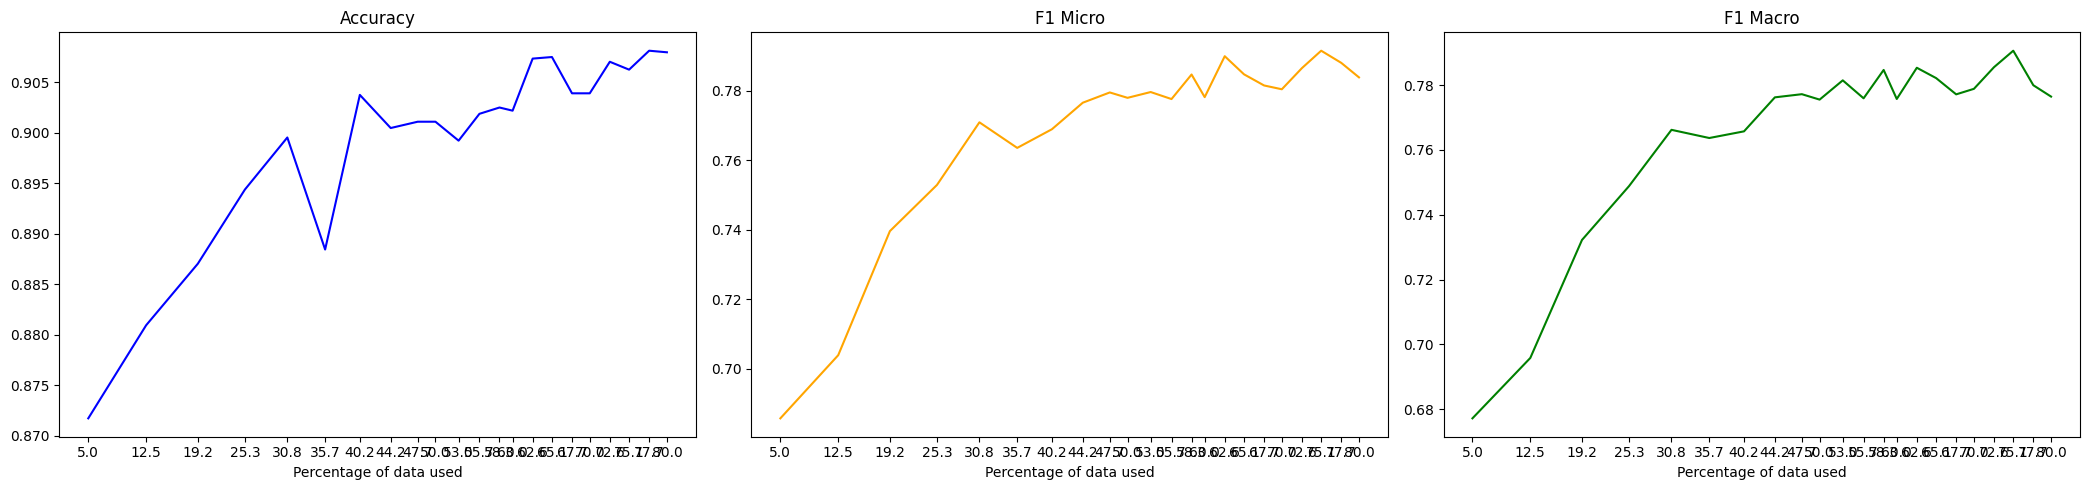

In [21]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5444, Accuracy: 0.8144, F1 Micro: 0.2404, F1 Macro: 0.1789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4029, Accuracy: 0.8344, F1 Micro: 0.4011, F1 Macro: 0.2841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3045, Accuracy: 0.8667, F1 Micro: 0.6049, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2544, Accuracy: 0.8758, F1 Micro: 0.6806, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2114, Accuracy: 0.8819, F1 Micro: 0.6914, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1614, Accuracy: 0.8844, F1 Micro: 0.6989, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.8844, F1 Micro: 0.6989, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.8842, F1 Micro: 0.7082, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5081, Accuracy: 0.8272, F1 Micro: 0.3393, F1 Macro: 0.2361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3478, Accuracy: 0.8475, F1 Micro: 0.4847, F1 Macro: 0.3533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2577, Accuracy: 0.8709, F1 Micro: 0.6446, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.8803, F1 Micro: 0.6743, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.8927, F1 Micro: 0.7453, F1 Macro: 0.7358
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.8878, F1 Micro: 0.7095, F1 Macro: 0.6963
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.8853, F1 Micro: 0.6903, F1 Macro: 0.6714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.8933, F1 Micro: 0.7555, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.8891, F1 Micro: 0.7142, F1 Macro: 0.7072
Epoch 10/10, Train Loss: 0.0495, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4724, Accuracy: 0.8444, F1 Micro: 0.4818, F1 Macro: 0.4022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3131, Accuracy: 0.8731, F1 Micro: 0.6463, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.8888, F1 Micro: 0.7238, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.8947, F1 Micro: 0.742, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.8972, F1 Micro: 0.759, F1 Macro: 0.757
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.893, F1 Micro: 0.7261, F1 Macro: 0.717
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.8936, F1 Micro: 0.7343, F1 Macro: 0.7297
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.8961, F1 Micro: 0.7465, F1 Macro: 0.7439
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.8925, F1 Micro: 0.7302, F1 Macro: 0.7295
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.8903, F1 Micro: 0.7176, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4508, Accuracy: 0.8461, F1 Micro: 0.4813, F1 Macro: 0.3955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.8833, F1 Micro: 0.7378, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.8938, F1 Micro: 0.7391, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.8958, F1 Micro: 0.7471, F1 Macro: 0.7391
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.8947, F1 Micro: 0.747, F1 Macro: 0.7425
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.8931, F1 Micro: 0.7296, F1 Macro: 0.7231
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.8919, F1 Micro: 0.721, F1 Macro: 0.7106
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.8911, F1 Micro: 0.7318, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.8936, F1 Micro: 0.7495, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0385, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.436, Accuracy: 0.8483, F1 Micro: 0.481, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.8791, F1 Micro: 0.6825, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.8897, F1 Micro: 0.713, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.8988, F1 Micro: 0.7521, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9005, F1 Micro: 0.7732, F1 Macro: 0.7724
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.8958, F1 Micro: 0.7443, F1 Macro: 0.7362
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.898, F1 Micro: 0.7499, F1 Macro: 0.7433
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8973, F1 Micro: 0.7551, F1 Macro: 0.7457
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9027, F1 Micro: 0.7687, F1 Macro: 0.7609
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9016, F1 Micro: 0.7663, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4434, Accuracy: 0.8711, F1 Micro: 0.6567, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.893, F1 Micro: 0.739, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8989, F1 Micro: 0.7653, F1 Macro: 0.7627
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.8978, F1 Micro: 0.7498, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.89, F1 Micro: 0.7704, F1 Macro: 0.7712
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9033, F1 Micro: 0.7618, F1 Macro: 0.7604
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9008, F1 Micro: 0.7606, F1 Macro: 0.757
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.898, F1 Micro: 0.7456, F1 Macro: 0.7301
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9008, F1 Micro: 0.7603, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.8945, F1 Micro: 0.767, F1 Macro: 0.7687

 Iteration 3122: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.417, Accuracy: 0.8802, F1 Micro: 0.7062, F1 Macro: 0.6984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2641, Accuracy: 0.8881, F1 Micro: 0.7138, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.8975, F1 Micro: 0.7534, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9, F1 Micro: 0.7659, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9017, F1 Micro: 0.7678, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9022, F1 Micro: 0.7623, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9009, F1 Micro: 0.7711, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8981, F1 Micro: 0.7735, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8992, F1 Micro: 0.7483, F1 Macro: 0.7396
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8653, F1 Micro: 0.6152, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8923, F1 Micro: 0.744, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.8969, F1 Micro: 0.7646, F1 Macro: 0.7648
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9003, F1 Micro: 0.7625, F1 Macro: 0.7618
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9034, F1 Micro: 0.7605, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.8997, F1 Micro: 0.7418, F1 Macro: 0.7328
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9025, F1 Micro: 0.7617, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.8981, F1 Micro: 0.7706, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.8994, F1 Micro: 0.7631, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9002, F1 Micro: 0.7746, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4178, Accuracy: 0.8792, F1 Micro: 0.6841, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.8927, F1 Micro: 0.7328, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.8989, F1 Micro: 0.7563, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9025, F1 Micro: 0.7644, F1 Macro: 0.7626
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.8983, F1 Micro: 0.7606, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9036, F1 Micro: 0.7683, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9006, F1 Micro: 0.7669, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9013, F1 Micro: 0.7647, F1 Macro: 0.7592
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9, F1 Micro: 0.7599, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.902, F1 Micro: 0.7654, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8775, F1 Micro: 0.6942, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8969, F1 Micro: 0.7526, F1 Macro: 0.7406
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.8966, F1 Micro: 0.7422, F1 Macro: 0.7348
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.8992, F1 Micro: 0.7524, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9023, F1 Micro: 0.7695, F1 Macro: 0.7616
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.8986, F1 Micro: 0.7592, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9003, F1 Micro: 0.7596, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9005, F1 Micro: 0.78, F1 Macro: 0.7788
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9009, F1 Micro: 0.7647, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.394, Accuracy: 0.8822, F1 Micro: 0.6974, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.8963, F1 Micro: 0.7438, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9013, F1 Micro: 0.7676, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9053, F1 Micro: 0.7772, F1 Macro: 0.7705
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9045, F1 Micro: 0.7672, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.8956, F1 Micro: 0.7769, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9031, F1 Micro: 0.7717, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.8969, F1 Micro: 0.7543, F1 Macro: 0.7423
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9031, F1 Micro: 0.7741, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.903, F1 Micro: 0.7704, F1 Macro: 0.7663

 Iteration 4330: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3949, Accuracy: 0.8806, F1 Micro: 0.7084, F1 Macro: 0.7027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.8947, F1 Micro: 0.7408, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9013, F1 Micro: 0.776, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.8964, F1 Micro: 0.7791, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9033, F1 Micro: 0.7804, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9016, F1 Micro: 0.7684, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9031, F1 Micro: 0.7727, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9022, F1 Micro: 0.7737, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9059, F1 Micro: 0.7844, F1 Macro: 0.7832
Epoch 10/10, Train Loss: 0.0371, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8763, F1 Micro: 0.7173, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.897, F1 Micro: 0.7641, F1 Macro: 0.759
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9022, F1 Micro: 0.7638, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9025, F1 Micro: 0.7687, F1 Macro: 0.7618
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9013, F1 Micro: 0.7541, F1 Macro: 0.745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.8998, F1 Micro: 0.7702, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9019, F1 Micro: 0.753, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9031, F1 Micro: 0.7794, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.8958, F1 Micro: 0.7741, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9009, F1 Micro: 0.7696, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8858, F1 Micro: 0.7166, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9002, F1 Micro: 0.7609, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9009, F1 Micro: 0.7758, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9016, F1 Micro: 0.776, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9089, F1 Micro: 0.7771, F1 Macro: 0.7719
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.907, F1 Micro: 0.7764, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9013, F1 Micro: 0.7658, F1 Macro: 0.7619
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.8988, F1 Micro: 0.7652, F1 Macro: 0.7647
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.8995, F1 Micro: 0.7765, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9031, F1 Micro: 0.7732, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8838, F1 Micro: 0.7182, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.8978, F1 Micro: 0.7463, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.903, F1 Micro: 0.7672, F1 Macro: 0.7496
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9025, F1 Micro: 0.7651, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9011, F1 Micro: 0.7778, F1 Macro: 0.7777
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9042, F1 Micro: 0.7777, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.8998, F1 Micro: 0.772, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7792
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9045, F1 Micro: 0.7741, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9038, F1 Micro: 0.7729, F1 Macro: 0.7687

 Iteration 5063: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8863, F1 Micro: 0.7284, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.8981, F1 Micro: 0.7681, F1 Macro: 0.7634
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.8992, F1 Micro: 0.7483, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9042, F1 Micro: 0.7824, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9038, F1 Micro: 0.7789, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.903, F1 Micro: 0.7817, F1 Macro: 0.7807
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9044, F1 Micro: 0.7718, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9047, F1 Micro: 0.7785, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9052, F1 Micro: 0.7682, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9027, F1 Micro: 0.7798, F1 Macro: 0.7789

 Iteration 5263: Accuracy: 0.9042, F1 Micro: 0.7824,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8808, F1 Micro: 0.6741, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.8972, F1 Micro: 0.736, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.9011, F1 Micro: 0.7532, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.907, F1 Micro: 0.7821, F1 Macro: 0.7751
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9033, F1 Micro: 0.781, F1 Macro: 0.7786
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9023, F1 Micro: 0.777, F1 Macro: 0.7739
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9042, F1 Micro: 0.7783, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9062, F1 Micro: 0.7797, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9036, F1 Micro: 0.7676, F1 Macro: 0.758
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9017, F1 Micro: 0.7675, F1 Macro: 0.7634

 Iteration 5441: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8884, F1 Micro: 0.7107, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9022, F1 Micro: 0.7707, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.903, F1 Micro: 0.7713, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9038, F1 Micro: 0.7845, F1 Macro: 0.7834
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9045, F1 Micro: 0.7721, F1 Macro: 0.7671
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9003, F1 Micro: 0.7546, F1 Macro: 0.7408
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.903, F1 Micro: 0.7748, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.905, F1 Micro: 0.774, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9036, F1 Micro: 0.7711, F1 Macro: 0.7686
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.902, F1 Micro: 0.768, F1 Macro: 0.7619

 Iteration 5641: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.371, Accuracy: 0.8909, F1 Micro: 0.7432, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.9025, F1 Micro: 0.7729, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9034, F1 Micro: 0.7799, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9039, F1 Micro: 0.7871, F1 Macro: 0.7852
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9066, F1 Micro: 0.7764, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9045, F1 Micro: 0.7819, F1 Macro: 0.7805
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9048, F1 Micro: 0.7715, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9003, F1 Micro: 0.773, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9025, F1 Micro: 0.7778, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9031, F1 Micro: 0.7653, F1 Macro: 0.7554

 Iteration 5841: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.883, F1 Micro: 0.682, F1 Macro: 0.6781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.8994, F1 Micro: 0.7553, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9031, F1 Micro: 0.7625, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.907, F1 Micro: 0.7889, F1 Macro: 0.7881
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9058, F1 Micro: 0.7683, F1 Macro: 0.7559
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9039, F1 Micro: 0.7716, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9047, F1 Micro: 0.7793, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.91, F1 Micro: 0.7895, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9011, F1 Micro: 0.7821, F1 Macro: 0.7819
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9016, F1 Micro: 0.7796, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3601, Accuracy: 0.8903, F1 Micro: 0.7275, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.9022, F1 Micro: 0.7622, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.903, F1 Micro: 0.7823, F1 Macro: 0.7787
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7651
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.8977, F1 Micro: 0.7774, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9058, F1 Micro: 0.78, F1 Macro: 0.7752
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.8988, F1 Micro: 0.777, F1 Macro: 0.7786
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.8998, F1 Micro: 0.777, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9017, F1 Micro: 0.7688, F1 Macro: 0.7613
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.903, F1 Micro: 0.7749, F1 Macro: 0.7704

 Iteration 6218: Accuracy: 0.903, F1 Micro: 0.7823, F1 M

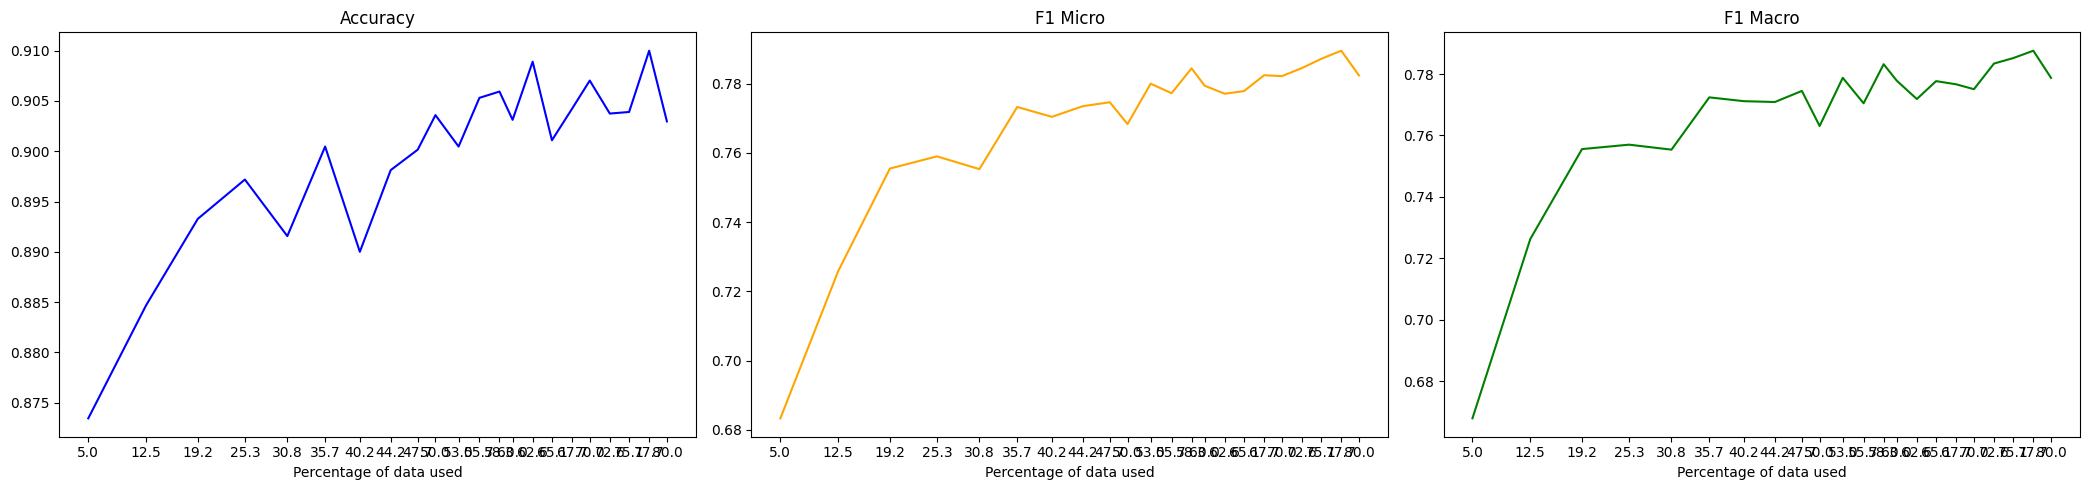

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.8159, F1 Micro: 0.242, F1 Macro: 0.1792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3776, Accuracy: 0.8314, F1 Micro: 0.3649, F1 Macro: 0.2552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3085, Accuracy: 0.8728, F1 Micro: 0.6551, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2434, Accuracy: 0.8752, F1 Micro: 0.6653, F1 Macro: 0.6445
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.8769, F1 Micro: 0.6647, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1588, Accuracy: 0.8834, F1 Micro: 0.7355, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.8883, F1 Micro: 0.7085, F1 Macro: 0.7025
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.8903, F1 Micro: 0.7205, F1 Macro: 0.7128
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.8863, F1 Micro: 0.6907, F1 Macro: 0.6714
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0684, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4836, Accuracy: 0.83, F1 Micro: 0.357, F1 Macro: 0.2468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3291, Accuracy: 0.8555, F1 Micro: 0.5409, F1 Macro: 0.4654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2693, Accuracy: 0.8716, F1 Micro: 0.6281, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2104, Accuracy: 0.8869, F1 Micro: 0.7185, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.8888, F1 Micro: 0.7212, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.89, F1 Micro: 0.7438, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.8911, F1 Micro: 0.7477, F1 Macro: 0.7453
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.8922, F1 Micro: 0.7309, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.8927, F1 Micro: 0.7305, F1 Macro: 0.7192
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4699, Accuracy: 0.8327, F1 Micro: 0.3791, F1 Macro: 0.2483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.873, F1 Micro: 0.6436, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2438, Accuracy: 0.8863, F1 Micro: 0.7302, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.8886, F1 Micro: 0.7513, F1 Macro: 0.7518
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.8895, F1 Micro: 0.7068, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.8942, F1 Micro: 0.7564, F1 Macro: 0.7555
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.8913, F1 Micro: 0.7327, F1 Macro: 0.7204
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.893, F1 Micro: 0.73, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.8975, F1 Micro: 0.7574, F1 Macro: 0.7551
Epoch 10/10, Train Loss: 0.0455, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.8363, F1 Micro: 0.3977, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2935, Accuracy: 0.8847, F1 Micro: 0.7295, F1 Macro: 0.7245
Epoch 3/10, Train Loss: 0.2276, Accuracy: 0.8869, F1 Micro: 0.7035, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.8977, F1 Micro: 0.7448, F1 Macro: 0.7313
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.8967, F1 Micro: 0.737, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.8986, F1 Micro: 0.7658, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.8938, F1 Micro: 0.7568, F1 Macro: 0.7558
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.8947, F1 Micro: 0.7617, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.8941, F1 Micro: 0.7487, F1 Macro: 0.7462
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.8969, F1 Micro: 0.7633, F1 Macro: 0.7616

 Iteration 2394: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4375, Accuracy: 0.858, F1 Micro: 0.5568, F1 Macro: 0.4645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2927, Accuracy: 0.8881, F1 Micro: 0.7231, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.8923, F1 Micro: 0.7638, F1 Macro: 0.7639
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.8955, F1 Micro: 0.7422, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.8936, F1 Micro: 0.7641, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.8969, F1 Micro: 0.7691, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.8961, F1 Micro: 0.7672, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.8963, F1 Micro: 0.7707, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9003, F1 Micro: 0.7677, F1 Macro: 0.7614
Epoch 10/10, Train Loss: 0.0389, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4239, Accuracy: 0.8553, F1 Micro: 0.5407, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.8919, F1 Micro: 0.7379, F1 Macro: 0.7318
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.8917, F1 Micro: 0.7288, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9031, F1 Micro: 0.7599, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.8956, F1 Micro: 0.7689, F1 Macro: 0.7645
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9016, F1 Micro: 0.7639, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9009, F1 Micro: 0.7737, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9044, F1 Micro: 0.7791, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9025, F1 Micro: 0.7752, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0384, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8608, F1 Micro: 0.5915, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.8936, F1 Micro: 0.7505, F1 Macro: 0.7407
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.8919, F1 Micro: 0.714, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9023, F1 Micro: 0.7582, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9022, F1 Micro: 0.7681, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.8991, F1 Micro: 0.7724, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9042, F1 Micro: 0.7786, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9017, F1 Micro: 0.7715, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.8966, F1 Micro: 0.7676, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.034, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4163, Accuracy: 0.8734, F1 Micro: 0.6419, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.8917, F1 Micro: 0.738, F1 Macro: 0.7304
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.8969, F1 Micro: 0.7364, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.8973, F1 Micro: 0.7676, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9013, F1 Micro: 0.7735, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.8984, F1 Micro: 0.7496, F1 Macro: 0.7377
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9008, F1 Micro: 0.7639, F1 Macro: 0.7542
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9017, F1 Micro: 0.7725, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.8992, F1 Micro: 0.7723, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9052, F1 Micro: 0.7722, F1 Macro: 0.766

 Iteration 3711: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8752, F1 Micro: 0.679, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.8927, F1 Micro: 0.7322, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9023, F1 Micro: 0.7784, F1 Macro: 0.7778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.902, F1 Micro: 0.7833, F1 Macro: 0.7835
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9014, F1 Micro: 0.7706, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9006, F1 Micro: 0.7707, F1 Macro: 0.7625
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9025, F1 Micro: 0.7679, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.902, F1 Micro: 0.7694, F1 Macro: 0.7627
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9017, F1 Micro: 0.777, F1 Macro: 0.7754
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9056, F1 Micro: 0.7823, F1 Macro: 0.7796

 Iteration 3886: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8714, F1 Micro: 0.6284, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.8938, F1 Micro: 0.7491, F1 Macro: 0.7389
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.8941, F1 Micro: 0.7182, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9003, F1 Micro: 0.7583, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.8964, F1 Micro: 0.7733, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9, F1 Micro: 0.7722, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9031, F1 Micro: 0.7717, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9019, F1 Micro: 0.7681, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.8997, F1 Micro: 0.7697, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9011, F1 Micro: 0.7758, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8805, F1 Micro: 0.7159, F1 Macro: 0.7098
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.8889, F1 Micro: 0.7066, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9019, F1 Micro: 0.7781, F1 Macro: 0.7705
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9016, F1 Micro: 0.7714, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9042, F1 Micro: 0.7802, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9042, F1 Micro: 0.7719, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.8992, F1 Micro: 0.7726, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9041, F1 Micro: 0.7787, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.8973, F1 Micro: 0.7686, F1 Macro: 0.7612

 Iteration 4330: Accuracy: 0.9042, F1 Micro: 0.7802, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.882, F1 Micro: 0.7279, F1 Macro: 0.726
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.8953, F1 Micro: 0.7279, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8927, F1 Micro: 0.777, F1 Macro: 0.7755
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9036, F1 Micro: 0.7765, F1 Macro: 0.7715
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.903, F1 Micro: 0.7724, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9045, F1 Micro: 0.7819, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9034, F1 Micro: 0.7783, F1 Macro: 0.7739
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9027, F1 Micro: 0.7714, F1 Macro: 0.7625
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9013, F1 Micro: 0.7718, F1 Macro: 0.7696
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9025, F1 Micro: 0.7701, F1 Macro: 0.7639

 Iteration 4530: Accuracy: 0.9045, F1 Micro: 0.7819, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8816, F1 Micro: 0.7048, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.8948, F1 Micro: 0.7599, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9025, F1 Micro: 0.7726, F1 Macro: 0.7655
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9008, F1 Micro: 0.7517, F1 Macro: 0.7457
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9031, F1 Micro: 0.7681, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9003, F1 Micro: 0.7757, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9066, F1 Micro: 0.7764, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9061, F1 Micro: 0.7817, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.905, F1 Micro: 0.7756, F1 Macro: 0.7648
Epoch 10/10, Train Loss: 0.0335, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8838, F1 Micro: 0.7184, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.8964, F1 Micro: 0.7431, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9044, F1 Micro: 0.7811, F1 Macro: 0.7764
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9048, F1 Micro: 0.772, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9028, F1 Micro: 0.7813, F1 Macro: 0.7765
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.907, F1 Micro: 0.7766, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9008, F1 Micro: 0.7774, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9081, F1 Micro: 0.7806, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9066, F1 Micro: 0.7772, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9033, F1 Micro: 0.7755, F1 Macro: 0.7705

 Iteration 4863: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8859, F1 Micro: 0.7157, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.8972, F1 Micro: 0.7351, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9052, F1 Micro: 0.7746, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9059, F1 Micro: 0.7814, F1 Macro: 0.7719
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9038, F1 Micro: 0.7703, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9028, F1 Micro: 0.7706, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9067, F1 Micro: 0.7858, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9034, F1 Micro: 0.7746, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9066, F1 Micro: 0.7806, F1 Macro: 0.7779
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9058, F1 Micro: 0.7818, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8839, F1 Micro: 0.7141, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9002, F1 Micro: 0.7657, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.8983, F1 Micro: 0.7803, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9066, F1 Micro: 0.7855, F1 Macro: 0.783
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9055, F1 Micro: 0.7781, F1 Macro: 0.7777
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.903, F1 Micro: 0.7847, F1 Macro: 0.7818
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9041, F1 Micro: 0.779, F1 Macro: 0.7776
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9052, F1 Micro: 0.7828, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9052, F1 Micro: 0.7761, F1 Macro: 0.7731
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.905, F1 Micro: 0.7773, F1 Macro: 0.7745

 Iteration 5263: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8836, F1 Micro: 0.6837, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.8986, F1 Micro: 0.731, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9039, F1 Micro: 0.7694, F1 Macro: 0.7603
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9027, F1 Micro: 0.7601, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9025, F1 Micro: 0.7804, F1 Macro: 0.7743
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9061, F1 Micro: 0.7731, F1 Macro: 0.7609
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9028, F1 Micro: 0.7796, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.902, F1 Micro: 0.7628, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8998, F1 Micro: 0.7744, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9042, F1 Micro: 0.7788, F1 Macro: 0.7743

 Iteration 5441: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8872, F1 Micro: 0.7227, F1 Macro: 0.7133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9, F1 Micro: 0.7619, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9052, F1 Micro: 0.7739, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9053, F1 Micro: 0.7814, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9064, F1 Micro: 0.7815, F1 Macro: 0.7767
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.902, F1 Micro: 0.7704, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9052, F1 Micro: 0.7766, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9064, F1 Micro: 0.783, F1 Macro: 0.7814
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8991, F1 Micro: 0.7791, F1 Macro: 0.7802
Epoch 10/10, Train Loss: 0.0276, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.882, F1 Micro: 0.6778, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9008, F1 Micro: 0.7623, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9064, F1 Micro: 0.7772, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9052, F1 Micro: 0.7782, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9011, F1 Micro: 0.7874, F1 Macro: 0.7872
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9003, F1 Micro: 0.778, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.8992, F1 Micro: 0.7686, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9064, F1 Micro: 0.7834, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9008, F1 Micro: 0.7762, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9033, F1 Micro: 0.7782, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.887, F1 Micro: 0.7469, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.8997, F1 Micro: 0.7572, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9058, F1 Micro: 0.7703, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9089, F1 Micro: 0.7845, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9059, F1 Micro: 0.7856, F1 Macro: 0.7818
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9039, F1 Micro: 0.7763, F1 Macro: 0.7717
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.903, F1 Micro: 0.7785, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9053, F1 Micro: 0.786, F1 Macro: 0.7812
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9042, F1 Micro: 0.7777, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0308, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8888, F1 Micro: 0.7236, F1 Macro: 0.7094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.9013, F1 Micro: 0.7508, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9055, F1 Micro: 0.7861, F1 Macro: 0.784
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9034, F1 Micro: 0.7754, F1 Macro: 0.7643
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9042, F1 Micro: 0.7775, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9033, F1 Micro: 0.7787, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.905, F1 Micro: 0.7735, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9033, F1 Micro: 0.7718, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9048, F1 Micro: 0.7778, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9058, F1 Micro: 0.7825, F1 Macro: 0.7778

 Iteration 6218: Accuracy: 0.9055, F1 Micro: 0.7861, F

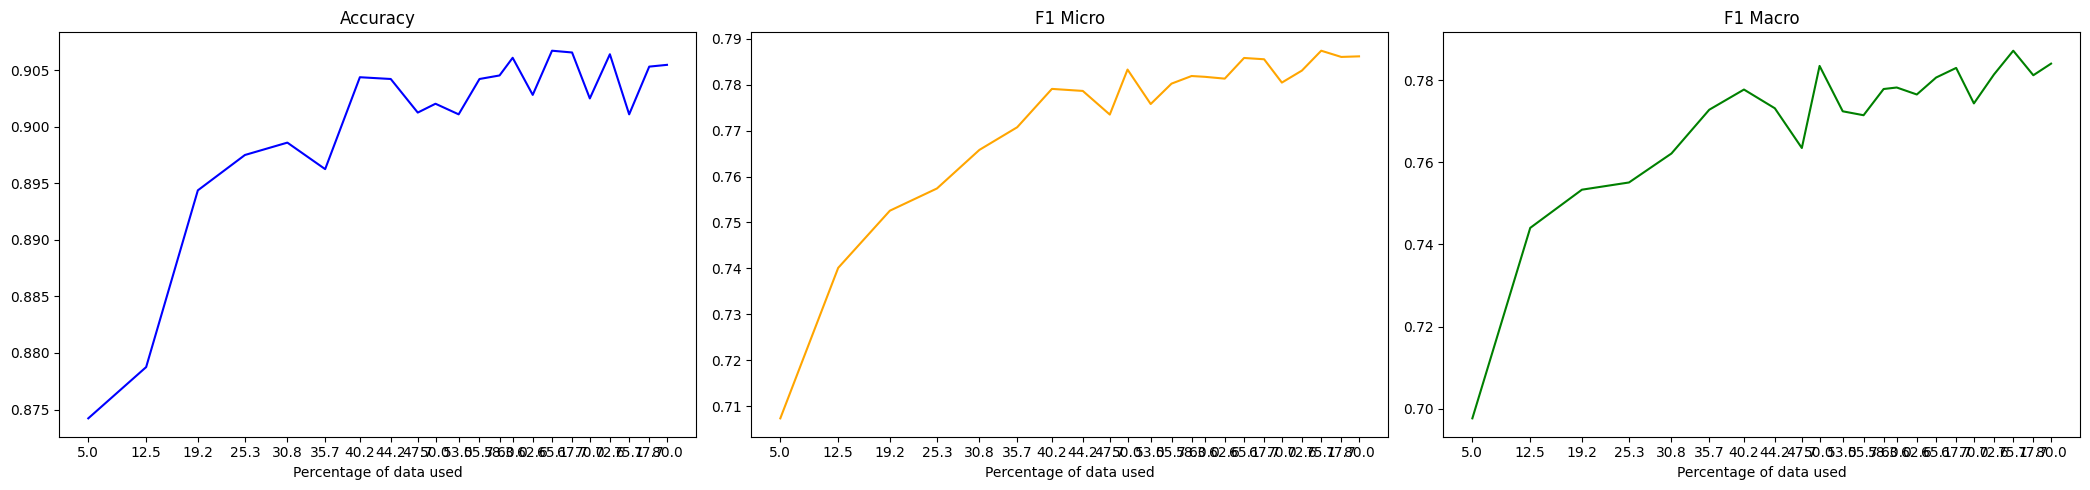

In [ ]:
active_learning(seeds[4], 4)